# Company Bankrupcy Prediction

https://www.kaggle.com/fedesoriano/company-bankruptcy-prediction

### Table of contents

1. Data overview
2. Target variable analysis
3. Features-target analysis \
3.1 Non-statistical test \
3.2 Monte Carlo analysis 
4. Multicollinearity
5. Data imbalance
6. SVM
7. Conclusion + links

***note:*** I will not explain the basic statistical / machine learning concepts. Some links are provided in the last section.

***important terminology note:***
- I am going to use these terms interchangeably
- *features = predictor variables = columns*
- *target variables = categories = classes*
- *datapoint = row of the dataset*

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, make_scorer, accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.feature_selection import RFE

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix

import delayed
from imblearn.over_sampling import SMOTE

import random
import itertools

import scipy

## 1. Data overview

In [45]:
df = pd.read_csv("data.csv")
print("Number of datapoints is %.d" %len(df))
df.head()
#df.describe()

Number of datapoints is 6819


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


It looks like the features are mostly numerical but I cannot see all 96 columns so I am going to look for categorical variables.

In [46]:
#looking for possibly categorical features
Filter = []

for col in df.columns:
    if df[col].nunique()<50: #quasi definition of categorical variable xd
        Filter.append(True)
    else:
        Filter.append(False)

categorical_c = df.loc[:,Filter] #filtering columns in this case

print(df.loc[:,Filter])

df = df.drop([' Liability-Assets Flag',' Net Income Flag'], 1)

df.shape

      Bankrupt?   Liability-Assets Flag   Net Income Flag
0             1                       0                 1
1             1                       0                 1
2             1                       0                 1
3             1                       0                 1
4             1                       0                 1
...         ...                     ...               ...
6814          0                       0                 1
6815          0                       0                 1
6816          0                       0                 1
6817          0                       0                 1
6818          0                       0                 1

[6819 rows x 3 columns]


(6819, 94)

It turns out that only two features are categorical (Liability-Assets Flag, Liability-Assets Flag) and they also happen to be useless because all datapoints have the same value. All other features are numerical.

## 2. Target variable analysis

The target is a dichotomous variable, I am going to have a look at the distribution of the two classes.

0    6599
1     220
Name: Bankrupt?, dtype: int64
Total percentage of bankrupted companies is 3.2 %.


D:\Anaconda2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


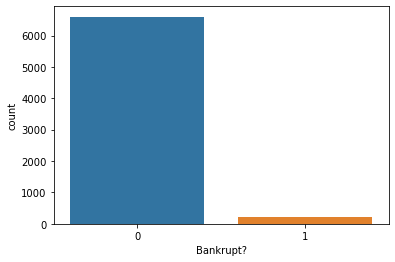

In [47]:
#analyzing Target variable (Class: 0 = Not Bankrupt, 1 = Bankrupt)

print(df["Bankrupt?"].value_counts())

percentage = df["Bankrupt?"].value_counts()[1]/len(df)
print("Total percentage of bankrupted companies is %.1f" %(percentage*100) + " %.")

sns.countplot(df["Bankrupt?"])
plt.show()

There is a huge imbalance between the two categories. It turns out that only 3.2% companies in this dataset bankrupted.

## 3. Variable-target analysis

Some companies bankrupted and some did not. I am not an economist and I sincerely know very little about the meaning of the predictor variables and bankrupcy. However, before proceeding with the analysis I would like to see at least a small evidence that the variables have effect on the bankrupcy.

### 3.1 Non-statistical test
Plotting the relative difference between the means of the features for both categories (bankrupted and not bankrupted).

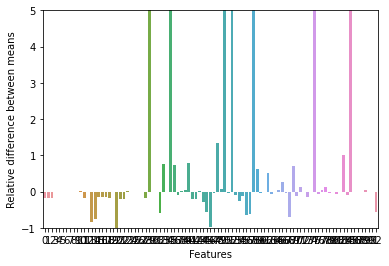

In [48]:
#Variables' effect on class

features = df.columns[1:] #from now on "features" are interchangable with "columns"

X = df[features]
y = df["Bankrupt?"]

X_0 = X.loc[y==0,:] #not bankrupted
X_1 = X.loc[y==1,:] #bakrupted

X_0_test = X_0.sample(n=220)

significant_cols = [] #features that have "very different" means
difs=[] #differences between means

for col in X.columns:
    relative_means_difference = (X_1[col].mean() - X_0_test[col].mean()) / X_0_test[col].mean() 
    difs.append([col,relative_means_difference])
    if abs(relative_means_difference)>0.5: #tresnhold, at least 50% freater/smaller mean 
        significant_cols.append(col)


sns.barplot(x=list(range(len(difs))),y=[e[1] for e in difs])
plt.ylim((-1,5)) #this controls the size of the window displayed
plt.xlabel("Features")
plt.ylabel("Relative difference between means")
plt.show()

There are a few features with really big differences and overall around 20 features whose means are more than 50% apart in these two categories.

### 3.2 Monte Carlo Hypothesis Test

#### HYPOTHESIS: There is a difference between bakrupted and not-bankrupted companies
(Null hypothesis: There is no difference between the bankrupted and not-bankrupted companies.)

I am going to generate 1000 samples, each containing 220 datapoints from <code>X</code> (- all datapoints) and obtain the sampling distribution of the sample mean for each feature. From the observed data (= the 220 datapoints of bankrupted companies) and sampling distribution I am going to determine the p-value.

***p-value for each feature:*** percentage of sample means that are more extreme than the bankrupt companies mean

In [49]:
#MONTE CARLO HYPOTESIS TEST

from statistics import mean

sampling_distribution = {feature: [] for feature in features} #SAMPLING DISTRIBUTION OF SAMPLE MEANS for each feature
bankrupt_means = {feature: X_1[feature].mean() for feature in features} #MEAN of each feature (observed data = bankrupt companies)

for i in range(1000): #sampling from the data 1000 times
    X_sample = X.sample(n=220) #n same as the number of bankrupt companies,sampling from X
    for feature in features:
        s_mean = X_sample[feature].mean()
        sampling_distribution[feature].append(s_mean)

pvalues = {feature: None for feature in features}

def get_p_value(sampling_distribution, observed):
    l = abs(observed-mean(sampling_distribution)) #distance of observed from the sample mean
    return sum(abs(sample_mean-mean(sampling_distribution))>l for sample_mean in sampling_distribution)/len(sampling_distribution) #the proportion of data more extreme than observed
               
for feature in pvalues: #filling the pvalues dictionary
    pvalues[feature] = get_p_value(sampling_distribution[feature],bankrupt_means[feature]) 

In [50]:
print("Number of significantly different features: %d" %sum(np.array(list(pvalues.values()))>0.05))
dict(itertools.islice(pvalues.items(),10)) #look at the first 10 features and associated p-values

Number of significantly different features: 34


{' ROA(C) before interest and depreciation before interest': 0.0,
 ' ROA(A) before interest and % after tax': 0.0,
 ' ROA(B) before interest and depreciation after tax': 0.0,
 ' Operating Gross Margin': 0.0,
 ' Realized Sales Gross Margin': 0.0,
 ' Operating Profit Rate': 0.98,
 ' Pre-tax net Interest Rate': 0.104,
 ' After-tax net Interest Rate': 0.095,
 ' Non-industry income and expenditure/revenue': 0.118,
 ' Continuous interest rate (after tax)': 0.091}

D:\Anaconda2\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda2\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda2\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warni

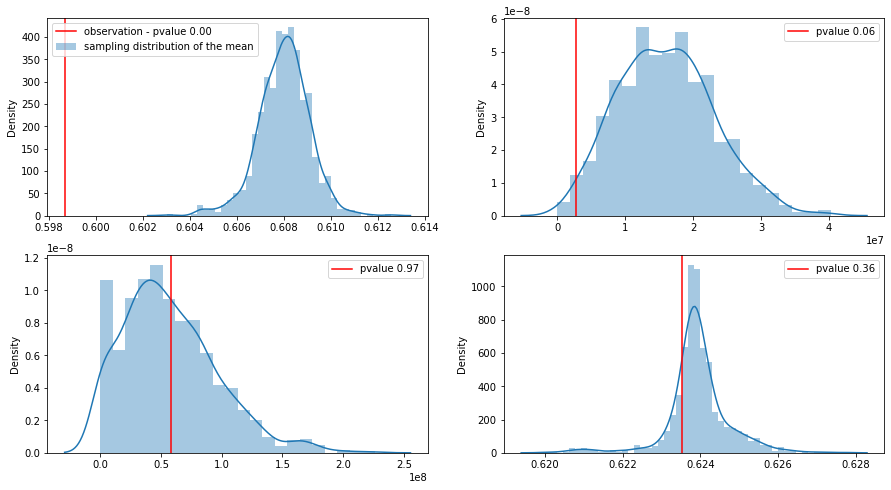

In [51]:
#Plotting some features and their distribution of sample means + red line with the mean of the observed data (= data of bankrupt companies)

fig, axes = plt.subplots(2,2, figsize=(15,8))

sns.distplot(sampling_distribution[" Operating Gross Margin"], ax=axes[0,0],label="sampling distribution of the mean")
axes[0,0].axvline(x=bankrupt_means[" Operating Gross Margin"],label="observation - pvalue %.2f"%pvalues[" Operating Gross Margin"],c="r")
axes[0,0].legend(loc='upper left')

sns.distplot(sampling_distribution[" Interest-bearing debt interest rate"], ax=axes[0,1])
axes[0,1].axvline(x=bankrupt_means[" Interest-bearing debt interest rate"],label="pvalue %.2f"%pvalues[" Interest-bearing debt interest rate"],c="r")
axes[0,1].legend()

sns.distplot(sampling_distribution[" Inventory/Current Liability"], ax=axes[1,0])
axes[1,0].axvline(x=bankrupt_means[" Inventory/Current Liability"],label="pvalue %.2f"%pvalues[" Inventory/Current Liability"],c="r")
axes[1,0].legend()

sns.distplot(sampling_distribution[" No-credit Interval"], ax=axes[1,1])
axes[1,1].axvline(x=bankrupt_means[" No-credit Interval"],label="pvalue %.2f"%pvalues[" No-credit Interval"],c="r")
axes[1,1].legend()

plt.legend()
plt.show()

I only exaimined the variables independently while there are probably many dependencies between them so I am not going to draw conclusions or perform feature selection based on these p-values.

## 4. Multicollinearity

I am going to find features with correlation coefficient greater than 0.9 and drop them.

In [52]:
#MULTICOLLINEARITY (CORRELATION BETWEEN PREDICTOR VARIABLES)

cor_matrix = df.corr().abs()
cor_matrix.style.background_gradient(sns.light_palette('red', as_cmap=True))

In [53]:
#Dropping correlated data

upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool)) #upper triangle of the correlation matrix

dropped_cols = set()
for feature in upper_tri.columns:
    if any(upper_tri[feature] > 0.9): #more than 0.9 corr. coeficient -> dropped
        dropped_cols.add(feature)

print("There are %d dropped columns" %len(dropped_cols))

X = X.drop(dropped_cols,axis=1)
X.head()

There are 19 dropped columns


,ROA(C) before interest and depreciation before interest,Operating Gross Margin,Operating Profit Rate,Non-industry income and expenditure/revenue,Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),...,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Total assets to GNP price,No-credit Interval,Net Income to Stockholder's Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
0,0.370594,0.601457,0.998969,0.302646,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,...,0.458609,0.520382,0.312905,0.118250,0.009219,0.622879,0.827890,0.026601,0.564050,0.016469
1,0.464291,0.610235,0.998946,0.303556,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,...,0.459001,0.567101,0.314163,0.047775,0.008323,0.623652,0.839969,0.264577,0.570175,0.020794
2,0.426071,0.601450,0.998857,0.302035,2.361297e-04,25500000.0,0.458521,0.000790,0.0,0.177911,...,0.459254,0.538491,0.314515,0.025346,0.040003,0.623841,0.836774,0.026555,0.563706,0.016474
3,0.399844,0.583541,0.998700,0.303350,1.078888e-04,0.0,0.465705,0.000449,0.0,0.154187,...,0.448518,0.604105,0.302382,0.067250,0.003252,0.622929,0.834697,0.026697,0.564663,0.023982
4,0.465022,0.598783,0.998973,0.303475,7.890000e+09,0.0,0.462746,0.000686,0.0,0.167502,...,0.454411,0.578469,0.311567,0.047725,0.003878,0.623521,0.839973,0.024752,0.575617,0.035490


PCA is a way to decorrelate and reduce the dimensionality of the data through the change of the basis. I am going to try if the method helps to decorrelate the data.

In [16]:
#PCA

scaler = StandardScaler() 
X_for_pca = pd.DataFrame(data=scaler.fit_transform(X),index=X.index,columns=X.columns) #standardized dataset

n_components = 10

pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(X_for_pca)
X_pc = pd.DataFrame(data=principal_components, columns=['PC %d'%d for d in range(n_components)])

print("Explained variance by 10 components %.2f" %sum(pca.explained_variance_ratio_))

Explained variance by 10 components 0.42


With 10 principal components the explained variance is still very low, so I do not find the PCA transformation useful for this data.

## 5. Data Imbalance

There is a huge imbalance between the data (only 3.2% companies from the dataset bankrupted). Before training a model I need to deal with this problem, otherwise the model would just predict every company to not bankrupt. 

I decided to try two ways:
1. ***Introducing weights*** \
Every datapoint from the minority class is considered "more important" than from the majority class, the weights for the two classes are inversely proportional to the number of datapoints in that class. Implemented within the SVM in next section.

2. ***SMOTE*** \
The Synthetic Minority Over-sampling TEchnique. \
Creates new synthetic datapoints using the k-nearest neighbor algorithm. \
With this method I am going to obtain the dataset where the value counts for both categories are the same.

In [54]:
#DATA IMBALANCE
#SMOTE 

sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X, y)

print('New balance of 1 and 0 classes (%):')
y_sm.value_counts()

New balance of 1 and 0 classes (%):


1    6599
0    6599
Name: Bankrupt?, dtype: int64

## 6. SVM 

I am going to train a SVM model. First with SMOTE-dataset, then without SMOTE data and lastly with SMOTE-dataset but reduced to 10% of the data.

The function <code>train_test_SVM(X,y)</code> has multiple steps:
1. Splitting the data
2. Assigning the weights
3. Creating a <code>Pipeline</code>
4. Using <code>GridSearchCV</code> to find the optimal hyperparameters \
Train the model
5. Score
6. Confusion matrix

The SVM training takes quite long (around 4 minutes for me).
- big amount of datapoints (perhaps too many for a SVM)
- <code>GridSearchCV</code> using cross validation for different (C, gamma) combinations
- training <code>'rbf'</code> kernel is slower than linear kernel

In [56]:
#SVM

def train_test_SVM(X,y):
    """Function finds the optimal hyperparameters of the SVM, plots the confusion matrix of test data, returns the model"""
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, stratify=y) #stratify adresses the unbalance only in the train test splitting
    
    sw_train = class_weight.compute_sample_weight(class_weight = 'balanced', y = y_train) #when balanced sw_train = [1.1.1...1]
    
    steps = [('scaler', StandardScaler()), ('SVM', SVC(cache_size=7000))]
    pipeline = Pipeline(steps)
    
    #parameters' names must match the 'SVM' name in Pipeline followed by two underscores!
    #standard SVM hyperparameters
    param_grid = {
    'SVM__C':[0.01,0.1,1,10],
    'SVM__gamma':[0.1,0.01,0.001,0.0001],
    'SVM__kernel':['rbf']
    }
    
    f1 = make_scorer(f1_score , average='macro')
    grid = GridSearchCV(pipeline,param_grid=param_grid, cv=5, scoring=f1, verbose=0) #verbose controls the training progression display!
    grid.fit(X_train, y_train, SVM__sample_weight = sw_train)
    
    print("best parameters: ")
    print(grid.best_params_)
    
    model = grid.best_estimator_
    y_pred = model.predict(X_test)
    
    print("f1 score is %.2f "%f1_score(y_test, y_pred))
    print("Precision: %.2f" %precision_score(y_test, y_pred))
    print("Recall: %.2f" %recall_score(y_test, y_pred))
    print("Precision: %.2f" %precision_score(y_test, y_pred))
    plot_confusion_matrix(model,
                         X_test,
                         y_test,
                         values_format='d')
    return model

best parameters: 
{'SVM__C': 10, 'SVM__gamma': 0.1, 'SVM__kernel': 'rbf'}
The f1 score is 0.99 
Precision: 0.98
Recall: 0.99
Precision: 0.98


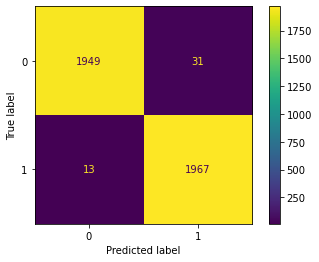

In [38]:
model = train_test_SVM(X_sm,y_sm)

best parameters: 
{'SVM__C': 0.1, 'SVM__gamma': 0.0001, 'SVM__kernel': 'rbf'}
The f1 score is 0.36 
Precision: 0.25
Recall: 0.64
Precision: 0.25


Pipeline(steps=[('scaler', StandardScaler()),
                ('SVM', SVC(C=0.1, cache_size=7000, gamma=0.0001))])

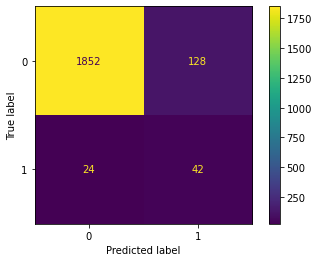

In [39]:
#Training and testing without SMOTE

train_test_SVM(X,y)

Without SMOTE the performance is a way worse. The model is not "meaningless" as it would be without the weights, however I suppose the weights are simply just "not enough" for such a big imbalance. 

best parameters: 
{'SVM__C': 10, 'SVM__gamma': 0.01, 'SVM__kernel': 'rbf'}
f1 score is 0.92 
Precision: 0.90
Recall: 0.94
Precision: 0.90


Pipeline(steps=[('scaler', StandardScaler()),
                ('SVM', SVC(C=10, cache_size=7000, gamma=0.01))])

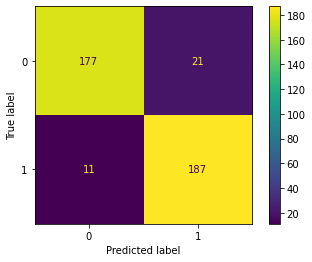

In [57]:
#Training and testing with 10% of the data

Xy_sm = pd.concat([X_sm,y_sm],axis=1)
Xy_reduced_1 = Xy_sm[Xy_sm["Bankrupt?"]==1].sample(frac=0.1) #taking 10% of the datapoints "Bankrupt?" = 1
Xy_reduced_0 = Xy_sm[Xy_sm["Bankrupt?"]==0].sample(frac=0.1) #taking 10% of the datapoints "Bankrupt?" = 0
Xy_reduced = pd.concat([Xy_reduced_1,Xy_reduced_0],axis=0) #the dataset is going to be shuffled in train_test_split

y_reduced = Xy_reduced["Bankrupt?"]
X_reduced = Xy_reduced.drop("Bankrupt?",axis=1)

train_test_SVM(X_reduced,y_reduced)

SVM does not use all the data to make a decision boundary, that is why the model works quite good with only 10% data. And the training is much faster.

## Conclusion and links

I preprocessed the data and trained an SVM estimator. I used a few widely used machine learning techniques along the way. However, there are more things that can be done to understand the data more. I would be interested in feature selection as well as applying other machine learning algorithms and observing the differences in their performance. 

### Sources: 
- PCA: https://www.youtube.com/watch?v=lrHboFMio7g&list=PLtV9G3anqB8B5s6FtBmqyc9VeZtlNp8GV&ab_channel=algomanic
- Imbalanced Data: https://towardsdatascience.com/imbalanced-data-when-details-matter-16bd3ec7ef74
- https://medium.com/@radecicdario
- https://brilliant.org/